<a href="https://colab.research.google.com/github/leon-lee-hub833/AUS_rain_prediction/blob/main/AUS_rain_prediction_use_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import data from Kaggle to Colab

In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
# creat path
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
#set permission
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# download dataset
!kaggle datasets download -d jsphyg/weather-dataset-rattle-package

Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
License(s): other
  0% 0.00/3.83M [00:00<?, ?B/s]
100% 3.83M/3.83M [00:00<00:00, 185MB/s]


In [ ]:
#unzip dataset
!unzip weather-dataset-rattle-package.zip

Archive:  weather-dataset-rattle-package.zip
  inflating: weatherAUS.csv          


# 2.Data perprocessing

In [ ]:
# import related library
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime # handle time and date
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing  #
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

In [ ]:
# import data
df = pd.read_csv("weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

the dataset contains about 10 years of daily weatherbservations from different locations across Australia.

There are 23 attributes

RainTomorrow is target indicating whether or not it will rain the next day

There are missing values in the dataset

Dataset includes numeric and categorical values

In [ ]:
numeric_df = df.select_dtypes(include=["int64", "float64"]).columns
categoric_df =df.select_dtypes(include=["object"]).columns


In [ ]:
# fill categoric missing value use median
for i in categoric_df:
    df[i] = df[i].fillna(df[i].mode()[0])

# fill mumeric missing value use median
for i in numeric_df:
    df[i] = df[i].fillna(df[i].median())


print(df.info())

In [ ]:
# deal the time sries
df['Date'] = pd.to_datetime(df["Date"]) # trasfor txt to datetime type
df['year'] = df.Date.dt.year  # extract year to put the new column named year


def encode(df, col, max_val): # 对月份和日进行周期性编码
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df


df['month'] = df.Date.dt.month   # extract month put in the new column named month
df = encode(df, 'month', 12)



df['day'] = df.Date.dt.day    # extract day put in the new column named day
df = encode(df, 'day', 31)



df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,4.8,8.4,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,4.8,8.4,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,4.8,8.4,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,4.8,8.4,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,4.8,8.4,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


## 3.Feature Engineering

In [ ]:
# tranfer categorical to neumeric type
label_encoder = LabelEncoder()
for i in categoric_df:
    df[i] = label_encoder.fit_transform(df[i])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  int64  
 1   Location       145460 non-null  int64  
 2   MinTemp        145460 non-null  float64
 3   MaxTemp        145460 non-null  float64
 4   Rainfall       145460 non-null  float64
 5   Evaporation    145460 non-null  float64
 6   Sunshine       145460 non-null  float64
 7   WindGustDir    145460 non-null  int64  
 8   WindGustSpeed  145460 non-null  float64
 9   WindDir9am     145460 non-null  int64  
 10  WindDir3pm     145460 non-null  int64  
 11  WindSpeed9am   145460 non-null  float64
 12  WindSpeed3pm   145460 non-null  float64
 13  Humidity9am    145460 non-null  float64
 14  Humidity3pm    145460 non-null  float64
 15  Pressure9am    145460 non-null  float64
 16  Pressure3pm    145460 non-null  float64
 17  Cloud9am       145460 non-nul

In [ ]:
# Prepairing attributes of scale data

features = df.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns 提取feature

target = df['RainTomorrow']  # extract target

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.501830e-16,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,3.001220e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,7.815677e-18,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,-3.282584e-17,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-5.424080e-16,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,6.252542e-18,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,1.824961e-16,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,7.190423e-17,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,8.284618e-17,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


<ipython-input-14-449e0c0d2169>:5: UserWarning: 
The palette list has fewer values (5) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


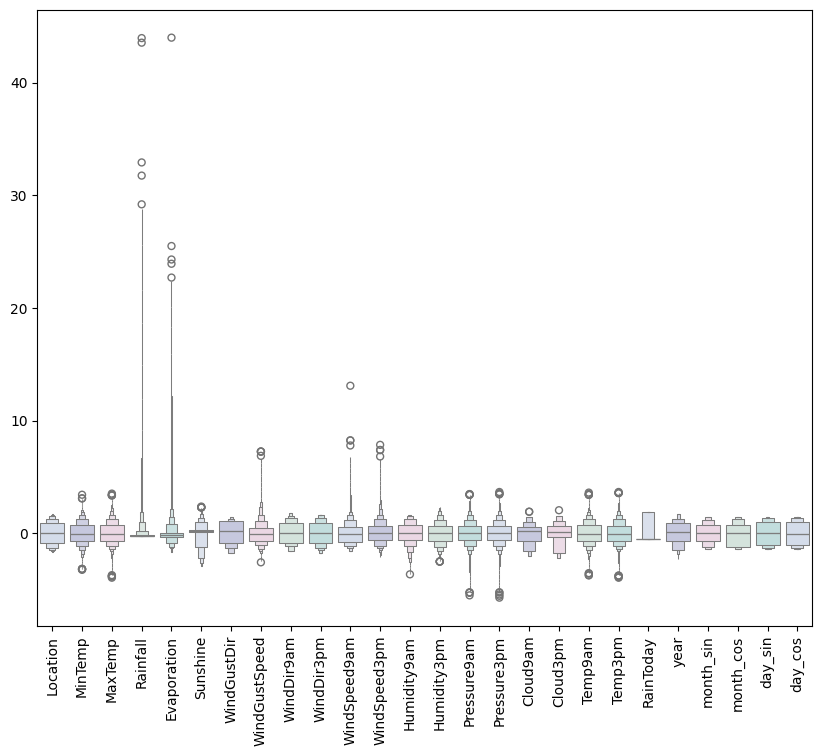

In [ ]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(10,8))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#full data for
features["RainTomorrow"] = target  # beacuse rows of features have to euqal with target, so we have to add target to features list

#Dropping with outlier
features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]  # -2.3<MinTemp<2.3
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

<ipython-input-16-d67240557b68>:4: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


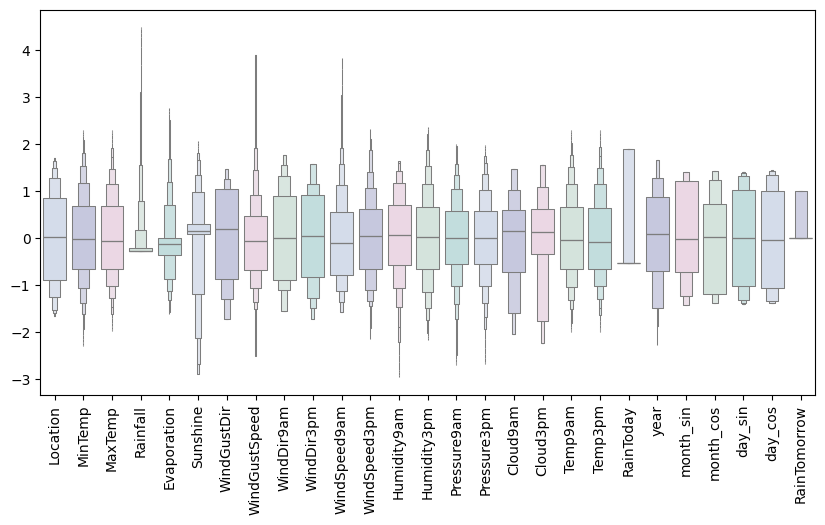

In [ ]:
#looking at the scaled features without outliers

plt.figure(figsize=(10,5))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Splitting test and training sets
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(127536, 26)

# 3.Creat modeling

In [ ]:
# Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

#Initialize a sequential model
model = Sequential()


# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26)) #1
# Dense represents a fully connected layer
# units represents have 32 node
# Kernel_initializer
# actibation function is relu (nonliner)
# input_idm repersents use 26 columns of features
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu')) #2
# same with first hidden laryer
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu')) #3
# 16 node
model.add(Dropout(0.25)) #4
# drop out 25% node,to aviod overfiting

model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu')) #5
# 8 node
model.add(Dropout(0.5)) #6
# drop out 50% node

model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))#7
# 1 node,
# use sigmoid function output binary task



# Compiling the ANN
opt = Adam(learning_rate=0.00009) # The Adam optimizer automatically adjusts the weights of all layers in the network
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
# use adam as optimizer
# use binary_crossentropy to measure the difference between predicted values and actual values.
# use accuracy evaluation metric to monitor the model's training performance.

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

# batch_size= 32， 32 simples divide in to one batch
# spochs=150, loop all simples once = spochs=1, spochs=150 means loop all simples 150 times
# callbacks=
# validation_split means train_data split to 20% validation and 80% train

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7842 - loss: 0.5419 - val_accuracy: 0.7860 - val_loss: 0.3922
Epoch 2/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7853 - loss: 0.4070 - val_accuracy: 0.7860 - val_loss: 0.3858
Epoch 3/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7841 - loss: 0.4058 - val_accuracy: 0.7860 - val_loss: 0.3828
Epoch 4/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8270 - loss: 0.4020 - val_accuracy: 0.8409 - val_loss: 0.3809
Epoch 5/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8389 - loss: 0.3994 - val_accuracy: 0.8413 - val_loss: 0.3791
Epoch 6/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8430 - loss: 0.3980 - val_accuracy: 0.8417 - val_loss: 0.3782
Epoch 7/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8422 - loss: 0.3993 - val_accuracy: 0.8428 - val_loss: 0.3767
Epoch 8/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8432 - los

# 4.Model evalution

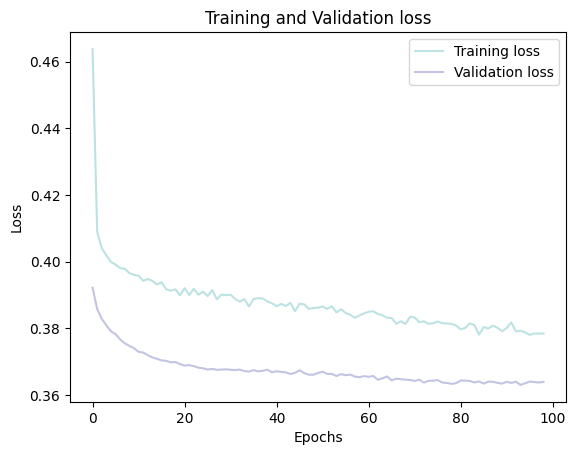

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

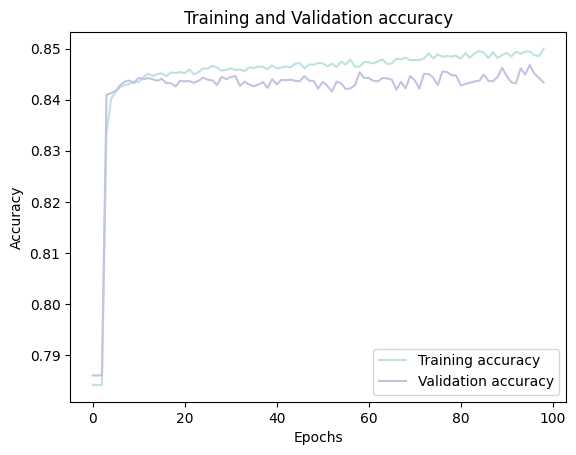

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 5.Predicting

In [ ]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

798/798 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# 6.Predictiong evalution

<Axes: >

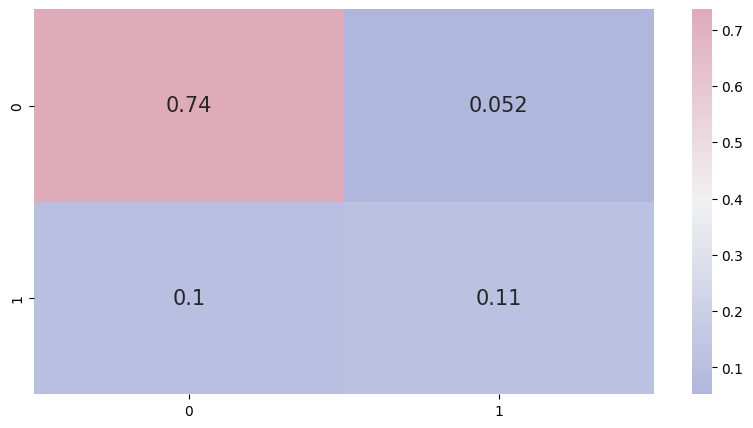

In [ ]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(10,5))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     20110
           1       0.68      0.53      0.59      5398

    accuracy                           0.85     25508
   macro avg       0.78      0.73      0.75     25508
weighted avg       0.84      0.85      0.84     25508

